<center><h1>Projet Robotique</h1></center>
<center><h2>Classification via LSTM</h2></center>

# Importation des librairies

In [1]:
!pip install bayesian-optimization

In [2]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from bayes_opt import BayesianOptimization

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.optimizers import Adam
from keras.api._v2.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')
# disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Configaration GPU

In [3]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at:{}".format(device_name))
else:
  device_name="/device:CPU:0"
  print("No GPU")

Found GPU at:/device:GPU:0


# Importation du dataset

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Robotique/preprocessed_data.csv")

df

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,-1.410530,0.693260,0.434434,0.074936,-0.199117,0.621667,-0.455638,...,0.147947,0.811792,0.186199,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,-1.626921,0.626338,0.487110,0.200034,-0.108635,0.598101,-0.542260,...,0.147947,0.812691,0.178270,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,-1.735116,0.470187,0.527630,0.179184,-0.099275,0.709202,-0.572130,...,0.147947,0.814490,0.172322,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,-1.616313,0.618902,0.523578,0.210459,-0.152316,0.729402,-0.593039,...,0.147947,0.816289,0.172322,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,-1.705415,0.570570,0.535734,0.161809,-0.189757,0.709202,-0.634857,...,0.149055,0.818988,0.176287,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.640278,0.298761,-0.141884,0.358651,0.102168,0.787298,0.418657,0.540867,-0.067329,...,0.129671,0.139901,0.208006,0,0,0,0,0,0,0
606044,1.407317,0.437804,0.297145,-0.020960,0.291729,0.102168,0.776873,0.452977,0.483633,-0.195770,...,0.129117,0.138102,0.206023,0,0,0,0,0,0,0
606045,1.407416,0.678242,0.240604,-0.001866,0.143014,0.110272,0.915871,0.393696,0.503833,-0.195770,...,0.129117,0.136303,0.202059,0,0,0,0,0,0,0
606046,1.407514,1.155955,0.159831,-0.046417,0.098399,0.256145,0.780348,0.362495,0.577900,-0.276418,...,0.129671,0.134504,0.200076,0,0,0,0,0,0,0


# Fonctions diverses

# Fonctions de feature selection

In [6]:
def dim_reduction(df, n):
  pca = PCA(n_components=n)
  pca.fit(df)
  reducted_df = pca.fit_transform(df)
  columns_name = ['column'+str(i) for i in range(1, pca.n_components_+1)]
  return pd.DataFrame(reducted_df, columns=columns_name)


In [7]:
def correlation(dataset, cor):
    df = dataset.copy()
    col_corr = set()  # For storing unique value
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > cor: # absolute values to handle positive and negative correlations
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    df.drop(col_corr,axis = 1,inplace = True)
    return df

## Fonction de segmentation du dataset  

In [8]:
def data_segmentation(dataCollection, window_size, label): # segment the data and create a dataset with locomotion classes as labels

    loco_i = dataCollection.columns.get_loc(label)
    #convert the data frame to numpy array
    data = dataCollection.to_numpy()
    #segment the data
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0

    while start + window_size - 1 < n:
        end = start + window_size-1
        if data[start][loco_i] == data[end][loco_i] and data[start][-1] == data[end][-1] : # if the frame contains the same activity and from the file
            X.append(data[start:(end+1),:])
            y.append(data[start][loco_i])
            start += window_size//2 # 50% overlap
        else: # if the frame contains different activities or from different objects, find the next start point
            while start + window_size-1 < n:
                if data[start][loco_i] != data[start+1][loco_i]:
                    break
                start += 1
            start += 1

    return np.asarray(X), np.asarray(y)

## Fonction d'entrainement du modèle

In [27]:
def lstm_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, v):
  nbn_l = int(nbn_l)
  nbn_d = int(nbn_d)
  bs = int(bs)
  with tf.device(device_name):

    model = Sequential()

    model.add(LSTM(units=nbn_l, activation='tanh', return_sequences=True, input_shape=X_train[0].shape))

    model.add(LSTM(units=nbn_l//2, activation='tanh', return_sequences=True, input_shape=X_train[0].shape))

    model.add(LSTM(units=nbn_l//4, activation='tanh', return_sequences=True, input_shape=X_train[0].shape))

    model.add(LSTM(units=nbn_l//8, activation='tanh'))

    model.add(Flatten())
    model.add(Dense(nbn_d, activation='elu'))
    model.add(Dropout(dp))
    model.add(Dense(nbn_l//2, activation='elu'))
    model.add(Dropout(dp))
    model.add(Dense(5, activation='softmax'))


    model.compile(optimizer = Adam(learning_rate=lr),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

    checkpointer = ModelCheckpoint(filepath='test.keras', monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

    history = model.fit(X_train, y_train,
                            batch_size=bs, epochs=100,
                            verbose=v,
                            callbacks = [checkpointer, early],
                            validation_data=(X_val, y_val))

    return history, model

## Fonction de la pipeline à utiliser

In [28]:
def pipeline(method,tresh,nbn_l, nbn_d, lr, bs, dp):

  if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
  elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

  labels = df[df.columns[-7:]]
  dataset = pd.concat([dataset, labels], axis=1)

  X, y = data_segmentation(dataCollection=df, window_size=25, label='HL_Activity')

  y = to_categorical(y)

  # split the data into train, validation and test sets using sklearn
  X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
  X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

  history, model = lstm_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, 0)
  acc = history.history['val_accuracy'][-1]

  return acc

# Affinage de la pipeline via l'optimisation Bayesienne

In [46]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    'nbn_l': (256, 1024),
    'nbn_d': (256, 1024),
    'lr': (1e-6, 1e-2),
    'bs': (32, 512),
    'dp': (0.1, 0.5)
    }


optimizer = BayesianOptimization(
    f=pipeline,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   |    bs     |    dp     |    lr     |  method   |   nbn_d   |   nbn_l   |   tresh   |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9838    | 232.2     | 0.3881    | 1.011e-06 | 0.6047    | 368.7     | 326.9     | 0.2658    |
| 2         | 0.9868    | 197.9     | 0.2587    | 5.434e-06 | 0.8384    | 782.2     | 413.0     | 0.8815    |
| 3         | 0.9868    | 45.15     | 0.3682    | 4.231e-05 | 1.117     | 363.8     | 408.1     | 0.8127    |
| 4         | 0.978     | 496.8     | 0.2254    | 6.954e-03 | 1.753     | 943.1     | 321.3     | 0.1348    |
| 5         | 0.9824    | 113.5     | 0.4513    | 1.074e-05 | 0.8422    | 991.7     | 665.5     | 0.7158    |
| 6         | 0.9648    | 183.4     | 0.3746    | 8.363e-05 | 0.03658   | 832.1     | 1.015e+03 | 0.7659    |
| 7         | 0.9883    | 166.6     | 0.4157    | 1.122e-04 | 0.8958    | 953.8     | 481.5     | 0.3561    |
| 8       

# Préparation du dataset pour l'entrainement avec les hyperparamètres optimaux

## Feature selection

In [17]:
method = optimizer['params']['method']
tresh = optimizer['params']['tresh']

if method <= 1:
  dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
  dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

dataset

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LH accX,Accelerometer LH accZ,...,Accelerometer FRIDGE accX,Accelerometer FRIDGE accY,LOCATION TAG1 X,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,-1.410530,0.693260,0.434434,0.074936,-0.199117,-0.287427,0.335051,...,-0.424433,0.568190,0.197956,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,-1.626921,0.626338,0.487110,0.200034,-0.108635,-0.223851,0.329940,...,-0.479332,0.206989,0.194403,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,-1.735116,0.470187,0.527630,0.179184,-0.099275,-0.386938,0.378494,...,-0.351234,0.413389,0.194995,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,-1.616313,0.618902,0.523578,0.210459,-0.152316,-0.328890,0.388716,...,-0.204835,1.084190,0.200324,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,-1.705415,0.570570,0.535734,0.161809,-0.189757,-0.447750,0.565044,...,-0.396983,0.258589,0.210983,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.640278,0.298761,-0.141884,0.358651,0.102168,0.787298,0.418657,-0.292956,0.253276,...,0.179460,0.206989,0.432449,0,0,0,0,0,0,0
606044,1.407317,0.437804,0.297145,-0.020960,0.291729,0.102168,0.776873,0.452977,-0.229379,0.243054,...,0.106261,0.310189,0.431857,0,0,0,0,0,0,0
606045,1.407416,0.678242,0.240604,-0.001866,0.143014,0.110272,0.915871,0.393696,-0.223851,0.161278,...,0.280108,-0.051012,0.432449,0,0,0,0,0,0,0
606046,1.407514,1.155955,0.159831,-0.046417,0.098399,0.256145,0.780348,0.362495,-0.135397,0.191944,...,0.097111,-0.309012,0.433633,0,0,0,0,0,0,0


## Segmentation du dataset

In [18]:
X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

X.shape, y.shape

((4122, 25, 91), (4122,))

## Division des données en train, val et test sets

In [19]:
# categorize the data
y = to_categorical(y)

# split the data into train, validation and test sets using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", X_train.shape)
print("Shape of the validation set: ", X_val.shape)
print("Shape of the test set: ", X_test.shape)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", y_train.shape)
print("Shape of the validation set: ", y_val.shape)
print("Shape of the test set: ", y_test.shape)

Shape of the train set:  (2761, 25, 91)
Shape of the validation set:  (681, 25, 91)
Shape of the test set:  (680, 25, 91)
Shape of the train set:  (2761, 5)
Shape of the validation set:  (681, 5)
Shape of the test set:  (680, 5)


# Entrainement du dataset avec les hyperparamètres optimaux

In [21]:
nbn_l = 256#optimizer['params']['nbn_l']
nbn_d = 512#optimizer['params']['nbn_d']
lr = 0.001#optimizer['params']['lr']
dp = 0.3#optimizer['params']['dp']
bs = 32#optimizer['params']['bs']

history, model = lstm_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, 2)

Epoch 1/100
87/87 - 10s - loss: 0.3928 - accuracy: 0.8624 - val_loss: 0.1662 - val_accuracy: 0.9427 - 10s/epoch - 115ms/step
Epoch 2/100
87/87 - 1s - loss: 0.1177 - accuracy: 0.9631 - val_loss: 0.0835 - val_accuracy: 0.9765 - 1s/epoch - 15ms/step
Epoch 3/100
87/87 - 1s - loss: 0.0852 - accuracy: 0.9739 - val_loss: 0.1221 - val_accuracy: 0.9662 - 1s/epoch - 12ms/step
Epoch 4/100
87/87 - 1s - loss: 0.0516 - accuracy: 0.9884 - val_loss: 0.0399 - val_accuracy: 0.9941 - 1s/epoch - 12ms/step
Epoch 5/100
87/87 - 1s - loss: 0.0143 - accuracy: 0.9964 - val_loss: 0.1413 - val_accuracy: 0.9692 - 1s/epoch - 12ms/step
Epoch 6/100
87/87 - 1s - loss: 0.0669 - accuracy: 0.9833 - val_loss: 0.0783 - val_accuracy: 0.9780 - 1s/epoch - 12ms/step
Epoch 7/100
87/87 - 1s - loss: 0.0189 - accuracy: 0.9960 - val_loss: 0.0205 - val_accuracy: 0.9941 - 1s/epoch - 13ms/step
Epoch 8/100
87/87 - 1s - loss: 0.0106 - accuracy: 0.9982 - val_loss: 0.0523 - val_accuracy: 0.9883 - 1s/epoch - 12ms/step
Epoch 9/100
87/87 - 1

# Evaluation du modèle

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.012211630120873451
Test accuracy: 0.9985294342041016


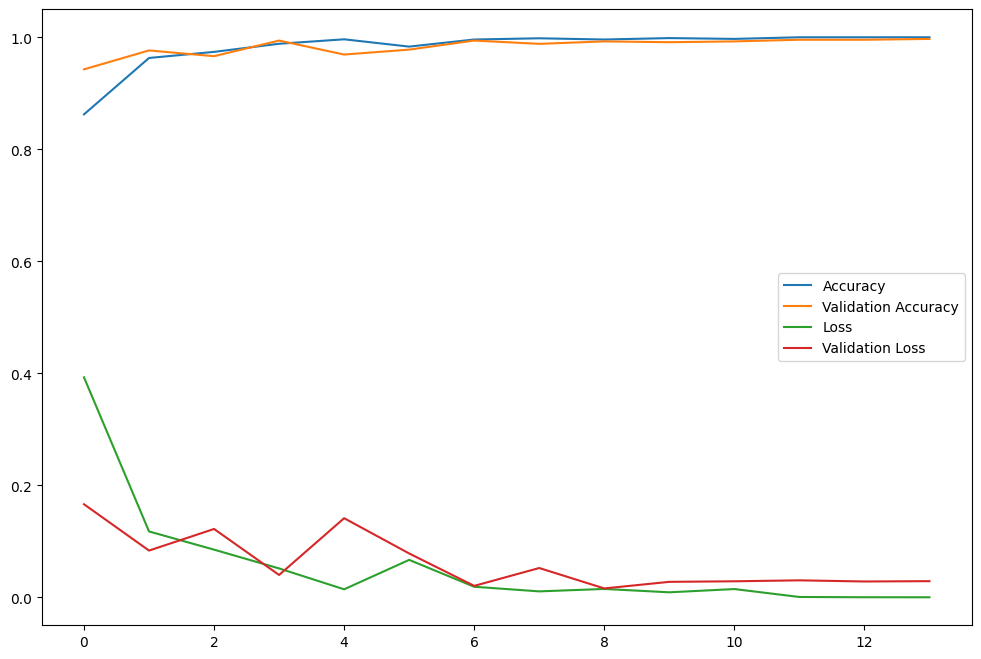

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

22/22 [==============================] - 2s 5ms/step


Text(0.5, 1.0, 'Confusion Matrix')

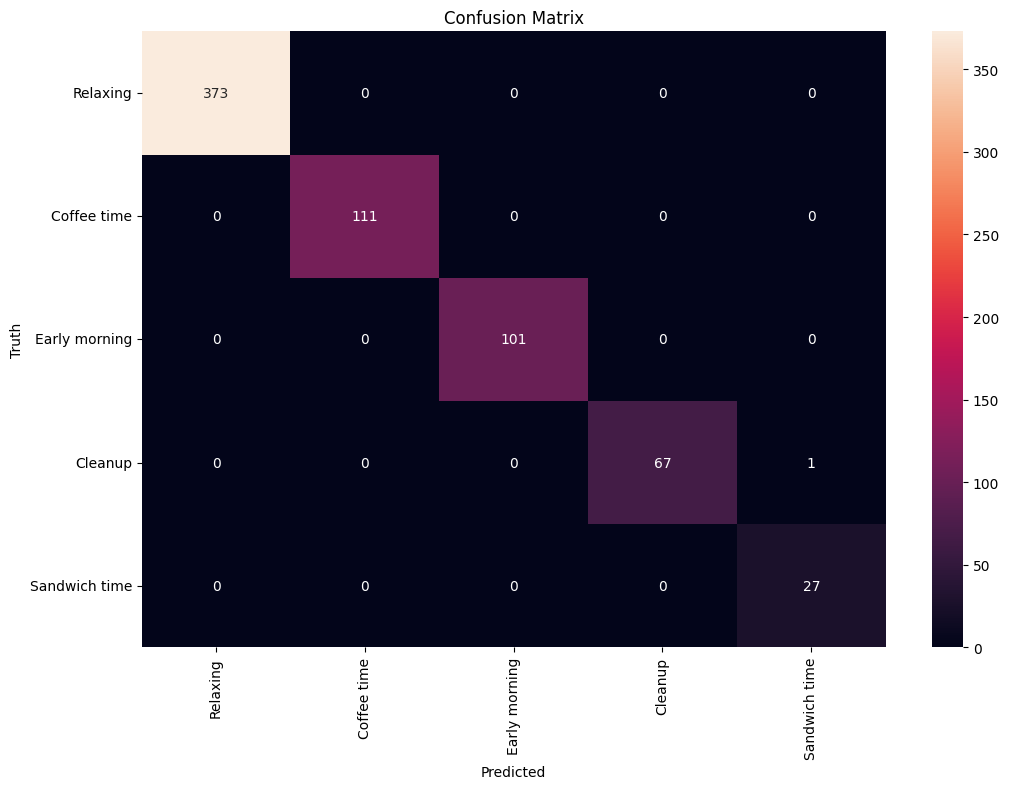

In [24]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")

In [25]:
classification_report(y_test, y_pred).split("\n")

['              precision    recall  f1-score   support',
 '',
 '           0       1.00      1.00      1.00       373',
 '           1       1.00      1.00      1.00       111',
 '           2       1.00      1.00      1.00       101',
 '           3       1.00      0.99      0.99        68',
 '           4       0.96      1.00      0.98        27',
 '',
 '    accuracy                           1.00       680',
 '   macro avg       0.99      1.00      0.99       680',
 'weighted avg       1.00      1.00      1.00       680',
 '']